Title: Predicting Heart Disease from Patient Chart Data

Introduction:

In Canada, 1 in 12 adults is living with heart disease(1). Currently, heart disease is the second leading cause of death in Canada and the number one cause globally (1,2). The ability for health care teams to accurately detect this disease early is crucial to ensure people receive care early when it will be most effective. Having a predictive model that can use common patient chart results to accurately predict the presence of heart disease will aid health care teams in assessing and treating patients as early as possible. This will help to lessen the burden of heart disease on individuals, by improving their prognosis, and the healthcare system as a whole. 

We will address the question “Can we accurately predict the presence of  heart disease using a selection of attributes found in patient charts?” using the Heart Disease Data Set from the UCI Machine Learning Repository. This data set contains a variety of attributes from patient charts with and without heart disease. This data set is a collection of information from patient charts with 76 attributes collected. We have chosen a subset of these attributes to use in our model to predict the presence of heart disease.

Preliminary exploratory data analysis:

In [36]:
library(tidyverse)
library(repr)
library(tidymodels)
library(digest)
library(ggplot2)
library(cowplot)
#options(repr.matrix.max.rows = 6)

In [37]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"

column_name <- c("age", 
                 "sex", 
                 "chest_pain_type", 
                 "resting_blood_pressure", 
                 "serum_cholesterol", 
                 "fasting_blood_sugar",
                 "resting_electrocardiographic_result", 
                 "maximum_heart_rate", 
                 "exercise_induced_angina",
                 "ST_depression_induced_by_exercise_relative_to_rest", 
                 "the_slope_of_the_peak_exercise_ST_segment", 
                 "number_of_major_vessels", 
                 "thal", 
                 "diagnosis_of_heart_disease")

heart_disease_data <- read_delim(url, delim = ",", col_names = column_name)

heart_disease_data <- heart_disease_data |>
        mutate(resting_blood_pressure = as_factor(resting_blood_pressure)) |>
        mutate(across(fasting_blood_sugar : thal, as_factor)) |>
        mutate(number_of_major_vessels = as.integer(number_of_major_vessels)) |>
        mutate(age = as.integer(age)) |>
        mutate(resting_blood_pressure = as.double(resting_blood_pressure)) |>
        mutate(maximum_heart_rate = as.double(maximum_heart_rate)) |>
        mutate(ST_depression_induced_by_exercise_relative_to_rest = 
        as.double(ST_depression_induced_by_exercise_relative_to_rest)) |>
        mutate(diagnosis_of_heart_disease = as_factor(diagnosis_of_heart_disease)) |>
        filter(resting_blood_pressure != 0) |>
        replace(heart_disease_data == "?", NA)

heart_disease_data$diagnosis_of_heart_disease <- ifelse(heart_disease_data $
                                                          diagnosis_of_heart_disease == 0, 
                                                          "false", "true")
heart_disease_data

heart_disease_split <- initial_split(heart_disease_data, 
                                     prop = 0.75, 
                                     strata = diagnosis_of_heart_disease)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, fasting_blood_sugar, resting_electrocardiog...
dbl (5): age, sex, chest_pain_type, serum_cholesterol, diagnosis_of_heart_di...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_electrocardiographic_result,maximum_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise_relative_to_rest,the_slope_of_the_peak_exercise_ST_segment,number_of_major_vessels,thal,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<chr>
32,1,1,1,0,NA,0,1,0,1,1,NA,NA,true
34,1,4,2,0,NA,NA,2,0,2,1,NA,NA,true
35,1,4,NA,0,NA,0,3,1,NA,NA,NA,7,true
36,1,4,4,0,NA,0,4,1,4,2,NA,6,true
38,0,4,5,0,NA,0,5,0,5,1,NA,NA,true
38,0,4,4,0,0,0,6,0,6,2,NA,3,true
38,1,3,6,0,NA,0,7,0,7,1,NA,NA,false
38,1,3,2,0,0,0,8,1,6,2,NA,7,true
38,1,4,7,0,NA,0,9,0,6,NA,NA,3,true


In [38]:
number_of_missing_data <- heart_disease_train|>
                          map_df(is.na)|>
                          map_df(sum)

number_of_each_class_observations <- heart_disease_train |>
                                     group_by(diagnosis_of_heart_disease) |>
                                     summarize(count = n())

number_of_missing_data
number_of_each_class_observations

age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_electrocardiographic_result,maximum_heart_rate,exercise_induced_angina,ST_depression_induced_by_exercise_relative_to_rest,the_slope_of_the_peak_exercise_ST_segment,number_of_major_vessels,thal,diagnosis_of_heart_disease
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,1,0,58,1,1,1,5,13,88,40,0


diagnosis_of_heart_disease,count
<chr>,<int>
false,8
true,84


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”


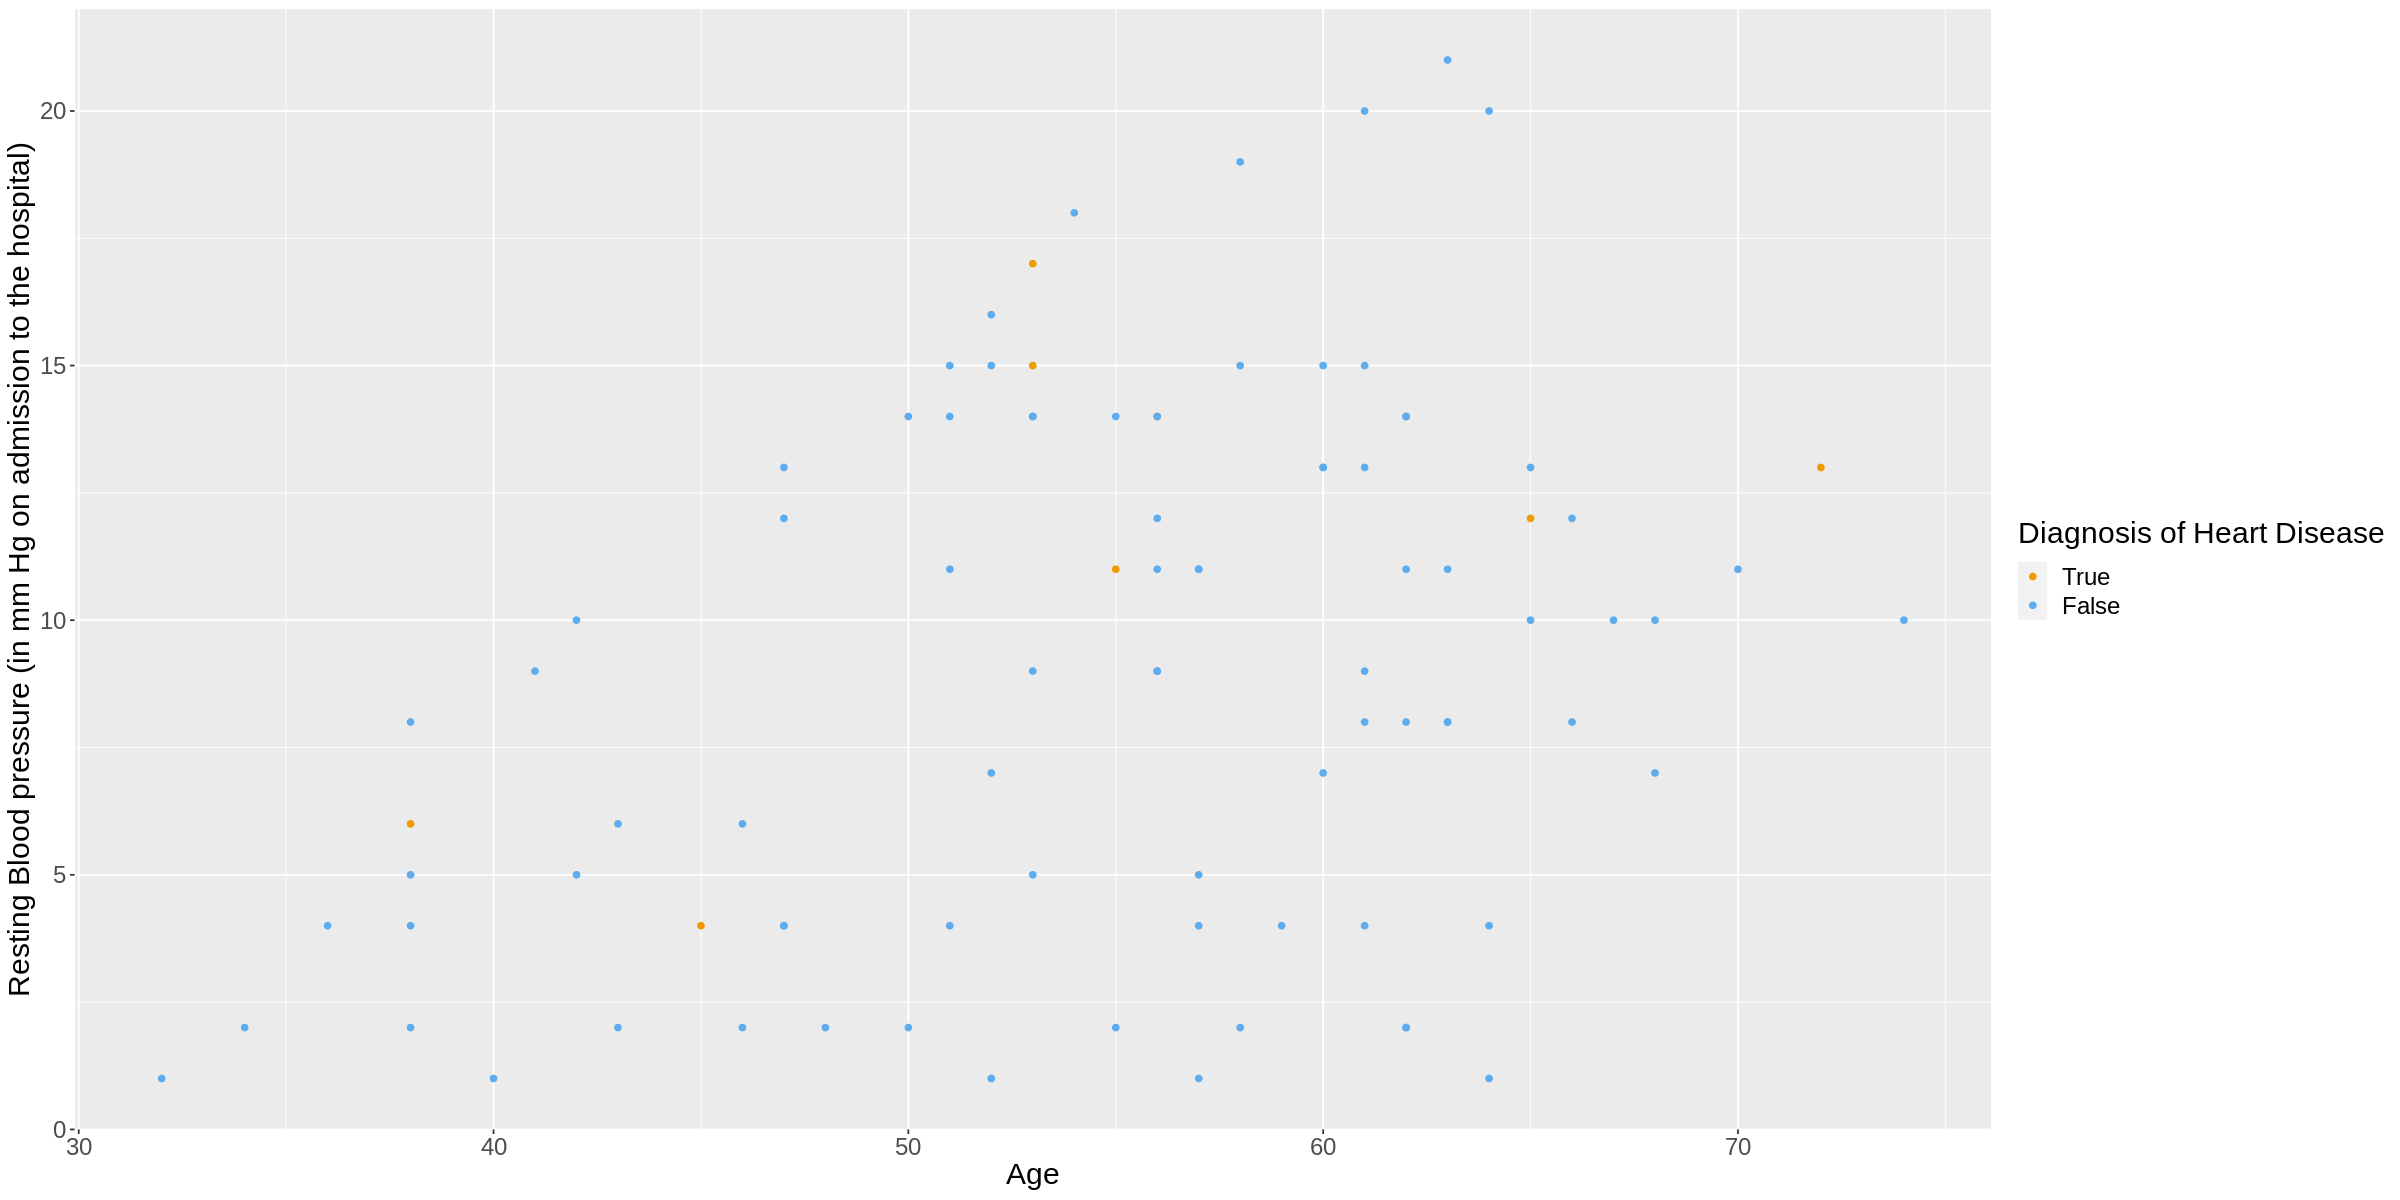

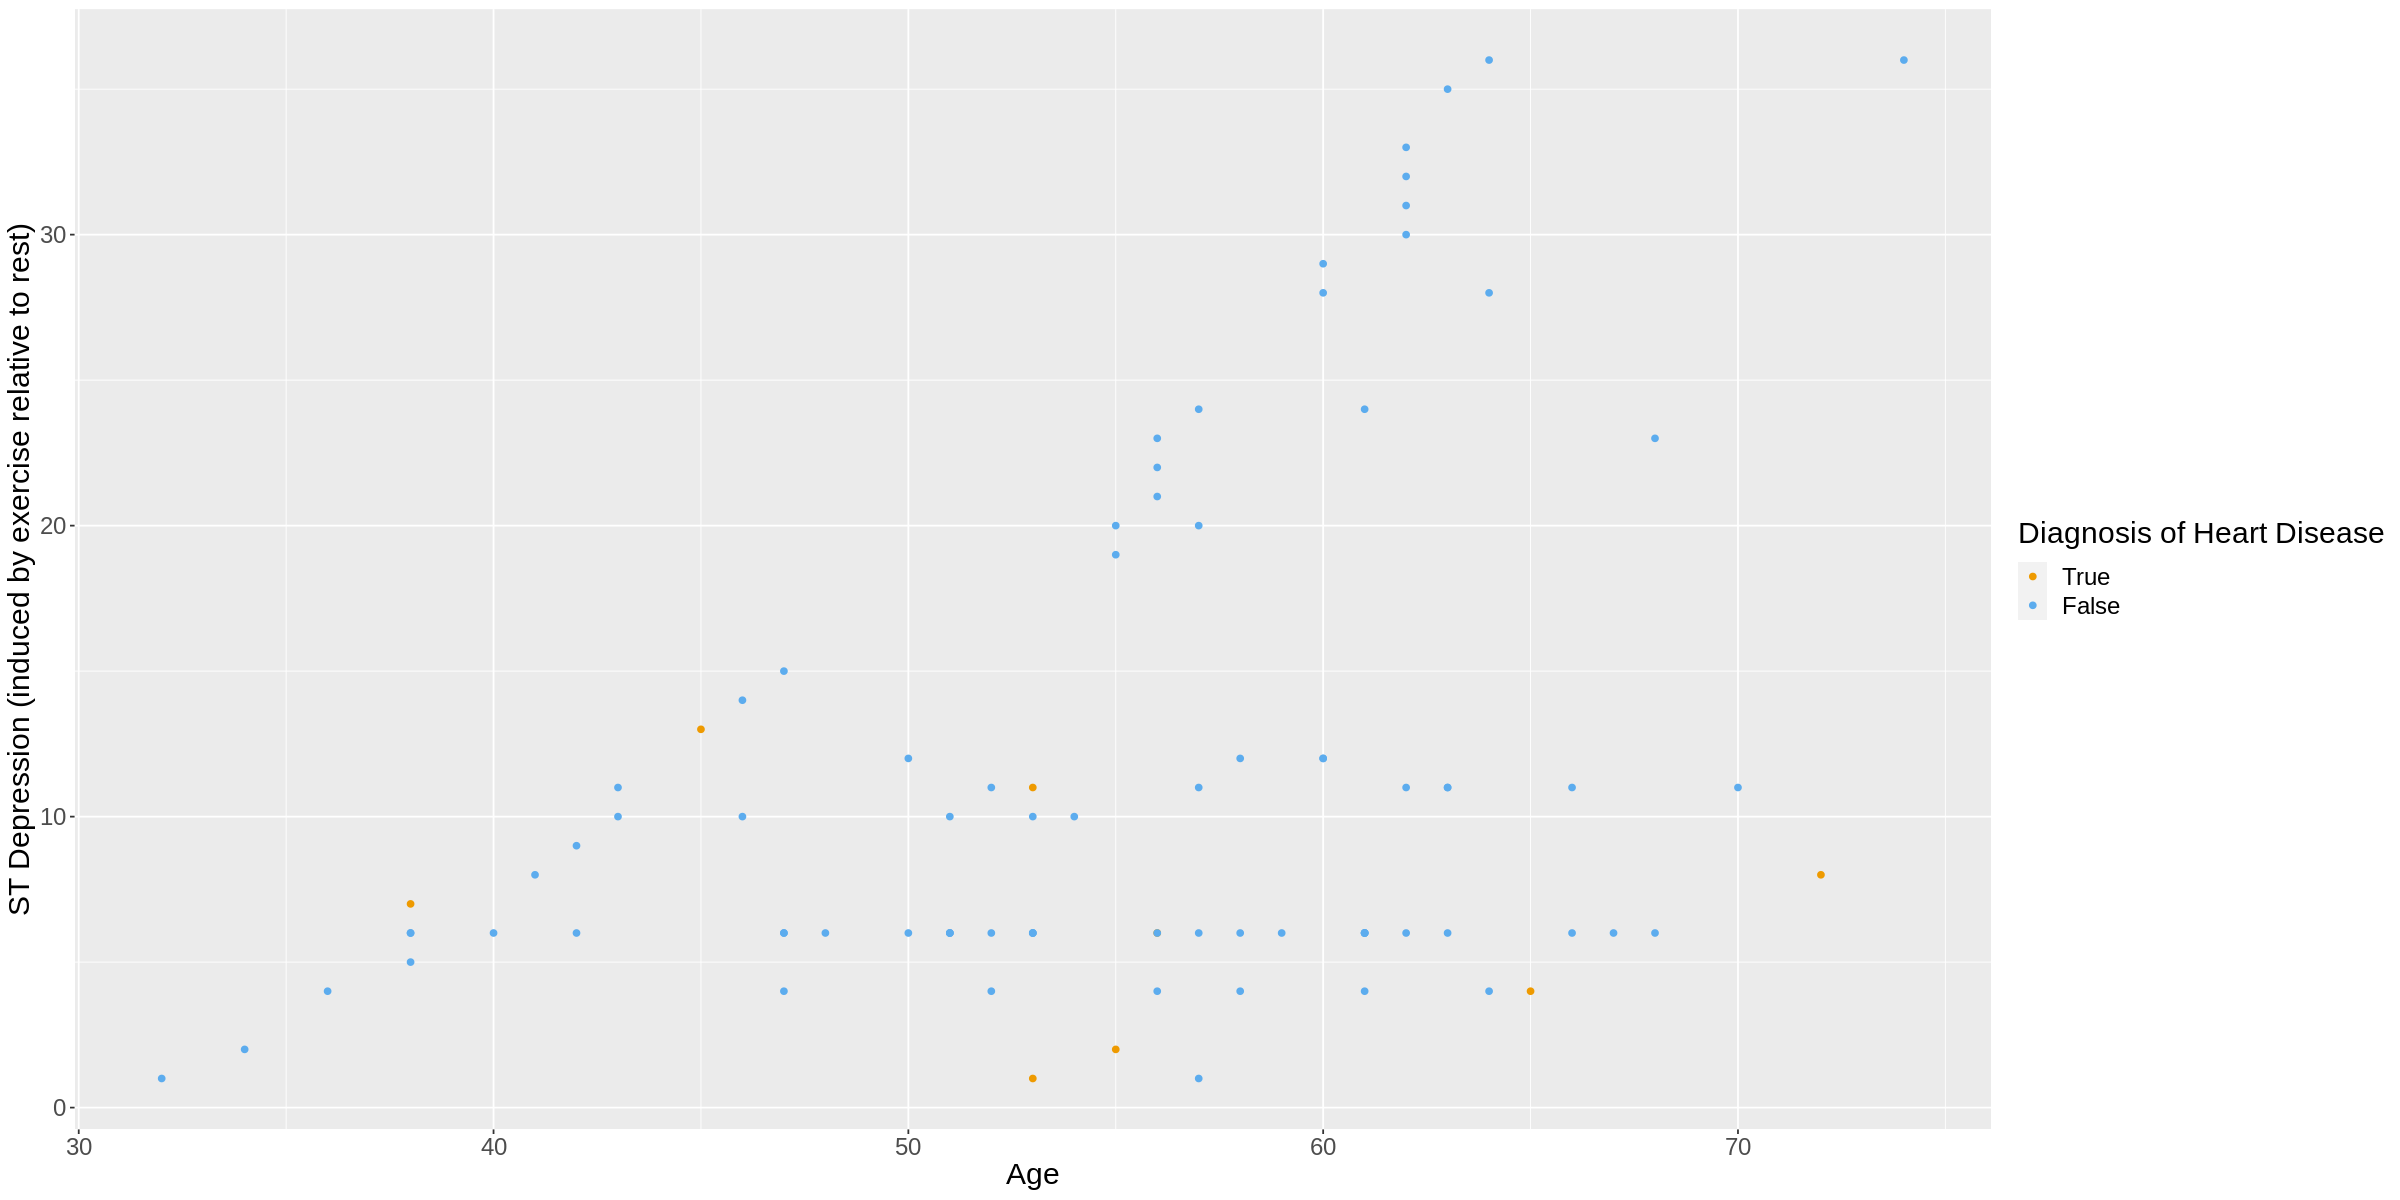

In [39]:
options(repr.plot.width = 20, repr.plot.height = 10)

age_resting_blood_pressure <- heart_disease_train |> 
                              ggplot(aes(x = age, 
                                         y = resting_blood_pressure, 
                                         color = diagnosis_of_heart_disease)) +
                              geom_point(alpha = 3.8) +
                              labs(x = "Age", 
                                   y = "Resting Blood pressure (in mm Hg on admission to the hospital)",
                                   color = "Diagnosis of Heart Disease") +
                              scale_color_manual(labels = c("True", "False"), 
                                                 values = c("orange2", "steelblue2")) +
                              theme(text = element_text(size = 18))

age_ST_depression <- heart_disease_train |> 
                         ggplot(aes(x = age, 
                                    y = ST_depression_induced_by_exercise_relative_to_rest, 
                                    color = diagnosis_of_heart_disease)) +
                         geom_point(alpha = 3.8) +
                         labs(x = "Age", 
                              y = "ST Depression (induced by exercise relative to rest)",
                              color = "Diagnosis of Heart Disease") +
                         scale_color_manual(labels = c("True", "False"), 
                                            values = c("orange2", "steelblue2")) +
                         theme(text = element_text(size = 18))

age_resting_blood_pressure
age_ST_depression

Methods:

We will develop a model to predict whether a patient has heart disease based on key pieces of information found in their chart. To do so, we have selected the Switzerland data from the Heart Disease Data sets. We will use this data to train and test our model to see if it can correctly predict heart disease based on selected predictors. The predictors chosed are: age, sex, cholesterol level, chest pain type, resting blood pressure, and exercise induced angina (heart pain). We will visualize our results using the scatter plot.

Expected outcomes and significance:

We expect our model will identify the presence of heart disease correctly and that there will be a positive correlation with older age, greater resting blood pressure, greater cholesterol level, and a greater severity of chest pain. We also expect that being a smoker and having a family history of heart disease be positively correlated with heart disease. 

If our model is successful, this tool may help healthcare workers accurately detect heart disease early and ensure individuals receive prompt and effective treatment. Ultimately, these changes in patient care will help to lessen the impacts of heart disease on individuals and potentially lessen the burden on the current healthcare system.

Our findings could lead to future questions such as whether there are specific diets or lifestyles that can actually reduce the risk of heart disease, or whether removing certain habits like smoking or a high cholesterol diet will reverse any harmful effects.

References
1. Public Health Agency of Canada (2022). Heart Disease in Canada. Retrieved from Government of Canada website: https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html
2. WHO’s Global Health Estimates (2020). The top 10 causes of death. Retrieved from the World Health Organization website: https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death

Word count: 456 (excluding references and preliminary exploratory data analysis)